In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Epoch    0 | Data 1.00e+00 | Phys 6.78e+03 | IC 9.13e-01
Epoch  200 | Data 5.48e-01 | Phys 8.12e+00 | IC 5.95e-09
Epoch  400 | Data 5.33e-01 | Phys 1.54e+01 | IC 4.36e-09
Epoch    0 | Data 5.28e-01 | Phys 2.04e+01 | IC 4.77e-09
Epoch  200 | Data 8.13e-01 | Phys 1.87e-01 | IC 4.97e-08
Epoch  400 | Data 7.87e-01 | Phys 1.86e-01 | IC 2.05e-08
Epoch  600 | Data 7.75e-01 | Phys 1.87e-01 | IC 1.87e-08
Epoch  800 | Data 7.69e-01 | Phys 1.86e-01 | IC 1.14e-07
Epoch 1000 | Data 7.64e-01 | Phys 1.85e-01 | IC 6.98e-08
Epoch 1200 | Data 7.59e-01 | Phys 1.84e-01 | IC 3.86e-08
Epoch 1400 | Data 7.54e-01 | Phys 1.84e-01 | IC 4.49e-08


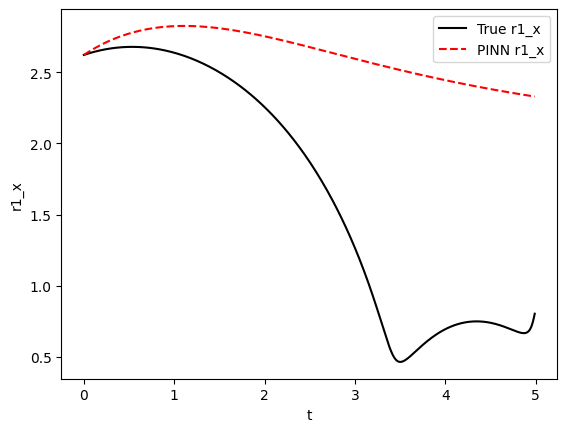

In [10]:
# ─── 1) GENERATE SIMULATION DATA ─────────────────────────────────────────────
n      = 3
G      = 3.0
masses = np.ones(n)

# Random ICs centered on COM
L, v_scale = 3.0, 0.5
pos0 = np.random.uniform(-L,L,(n,2))
vel0 = np.random.uniform(-v_scale,v_scale,(n,2))
Mtot = masses.sum()
COM_r = (masses[:,None]*pos0).sum(0)/Mtot
COM_v = (masses[:,None]*vel0).sum(0)/Mtot
pos0 -= COM_r;  vel0 -= COM_v

x0 = np.hstack((pos0.flatten(), vel0.flatten()))
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            rij = pos[i]-pos[j]
            acc[i] += -G*masses[j]*rij/np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

dt, Nt = 0.01, 500
t_sim = np.linspace(0, dt*(Nt-1), Nt)
sol   = solve_ivp(n_body_rhs, (0, t_sim[-1]), x0, t_eval=t_sim,
                  rtol=1e-9, atol=1e-9)
data_sim = sol.y.T  # (Nt,4n)

# Convert to tensors
t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)   # (Nt,1)
x_data = torch.tensor(data_sim, dtype=torch.float32)            # (Nt,4n)

# ─── 2) PINN DEFINITION ──────────────────────────────────────────────────────
class NBodyPINN(nn.Module):
    def __init__(self, n, hidden=[64,64]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

model     = NBodyPINN(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse       = nn.MSELoss()

# ─── 3) COLLocation POINTS ───────────────────────────────────────────────────
Ncol = 200
t_col = torch.tensor(
    np.random.uniform(0, t_sim[-1], (Ncol,1)),
    requires_grad=True,
    dtype=torch.float32
)

# ─── 4) LOSS FUNCTIONS ──────────────────────────────────────────────────────
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    t0     = torch.zeros(1,1) 
    x0_pred= model(t0)  
    x0_true= x_data[:1]  
    Li = mse(x0_pred, x0_true)
    return mse(x0_pred, x0_true)


def physics_loss():
    # Predict at collocation times
    x_pred = model(t_col)              # (Ncol,4n)
    # First derivative per output dim
    x_t_list = []
    for j in range(4*n):
        grad_j = ag.grad(x_pred[:,j], t_col,
                         grad_outputs=torch.ones_like(x_pred[:,j]),
                         create_graph=True)[0]
        x_t_list.append(grad_j)
    x_t = torch.cat(x_t_list, dim=1)   # (Ncol,4n)
    # Second derivative per output dim
    x_tt_list = []
    for j in range(4*n):
        grad2_j = ag.grad(x_t[:,j], t_col,
                          grad_outputs=torch.ones_like(x_t[:,j]),
                          create_graph=True)[0]
        x_tt_list.append(grad2_j)
    x_tt = torch.cat(x_tt_list, dim=1) # (Ncol,4n)

    # Extract predicted positions & accelerations
    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:,  :2*n].view(-1,n,2)

    # Build ODE residual
    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j] * rij / (rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# ─── 5) TRAINING ─────────────────────────────────────────────────────────────────
epochs = 2000

# Stage 1: match data & IC exactly
for epoch in range(500):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 

    loss = Ld + 1000.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")

# Stage 2: add physics back in
for epoch in range(1500):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 

    loss = Ld + Lp + 1000.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")


# ─── 6) EVALUATION ──────────────────────────────────────────────────────────
with torch.no_grad():
    x_pinn = model(t_data).cpu().numpy()  # (Nt,4n)

plt.figure()
plt.plot(t_sim, data_sim[:,0], 'k-', label='True r1_x')
plt.plot(t_sim, x_pinn[:,0], 'r--', label='PINN r1_x')
plt.legend(); plt.xlabel('t'); plt.ylabel('r1_x'); plt.show()

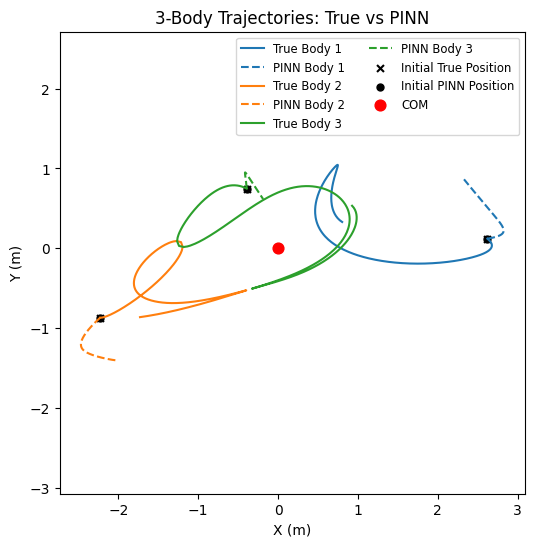

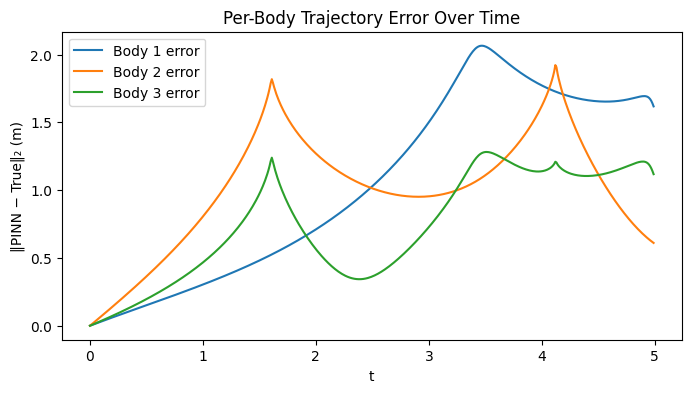

In [18]:
# ─── PLOTTING ─────────────────────────────────────────────────────────────────
# data_sim is (Nt,4n); transpose to (4n,Nt) to index as data[2*i,:]
data = data_sim.T  

plt.figure(figsize=(6,6))
for i in range(n):
    # true
    xi = data[2*i,    :]
    yi = data[2*i+1,  :]
    plt.plot(xi, yi, 'C'+str(i), lw=1.5, label=f'True Body {i+1}')
    # PINN
    xi_p = x_pinn[:,2*i]
    yi_p = x_pinn[:,2*i+1]
    plt.plot(xi_p, yi_p, '--', c=f'C{i}', lw=1.5, label=f'PINN Body {i+1}')

# same for the PINN initial:
initial_xs_p = x_pinn[0, 0:2*n:2]
initial_ys_p = x_pinn[0, 1:2*n:2]

# initial positions
initial_xs = data[0:2*n:2, 0]
initial_ys = data[1:2*n:2, 0]
plt.scatter(initial_xs, initial_ys, c='k', marker='x', s=25, label='Initial True Position')
plt.scatter(initial_xs_p, initial_ys_p, c='k', marker='o', s=25,label='Initial PINN Position')

plt.scatter(0,0, marker='o', c='r', s=60, label='COM')
plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories: True vs PINN')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()




# Error
errors = np.zeros((Nt, n))
for i in range(n):
    # pick out columns 2*i (x) and 2*i+1 (y)
    true_xy = data_sim[:, 2*i:2*i+2]   # (Nt,2)
    pred_xy = x_pinn[:,  2*i:2*i+2]    # (Nt,2)
    # Euclidean error per time
    errors[:, i] = np.linalg.norm(pred_xy - true_xy, axis=1)

plt.figure(figsize=(8,4))
for i in range(n):
    plt.plot(t_sim, errors[:,i], label=f'Body {i+1} error')
plt.xlabel('t')
plt.ylabel('‖PINN − True‖₂ (m)')
plt.title('Per-Body Trajectory Error Over Time')
plt.legend()
plt.show()


In [19]:
# ─── 1) GENERATE SIMULATION DATA ─────────────────────────────────────────────
n      = 2
G      = 3.0
masses = np.ones(n)

# Random ICs centered on COM
L, v_scale = 3.0, 0.5
pos0 = np.random.uniform(-L,L,(n,2))
vel0 = np.random.uniform(-v_scale,v_scale,(n,2))
Mtot = masses.sum()
COM_r = (masses[:,None]*pos0).sum(0)/Mtot
COM_v = (masses[:,None]*vel0).sum(0)/Mtot
pos0 -= COM_r;  vel0 -= COM_v

x0 = np.hstack((pos0.flatten(), vel0.flatten()))
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            rij = pos[i]-pos[j]
            acc[i] += -G*masses[j]*rij/np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

dt, Nt = 0.01, 500
t_sim = np.linspace(0, dt*(Nt-1), Nt)
sol   = solve_ivp(n_body_rhs, (0, t_sim[-1]), x0, t_eval=t_sim,
                  rtol=1e-9, atol=1e-9)
data_sim = sol.y.T  # (Nt,4n)

# Convert to tensors
t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)   # (Nt,1)
x_data = torch.tensor(data_sim, dtype=torch.float32)            # (Nt,4n)

# ─── 2) PINN DEFINITION ──────────────────────────────────────────────────────
class NBodyPINN(nn.Module):
    def __init__(self, n, hidden=[64,64]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

model     = NBodyPINN(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse       = nn.MSELoss()

# ─── 3) COLLocation POINTS ───────────────────────────────────────────────────
Ncol = 200
t_col = torch.tensor(
    np.random.uniform(0, t_sim[-1], (Ncol,1)),
    requires_grad=True,
    dtype=torch.float32
)

# ─── 4) LOSS FUNCTIONS ──────────────────────────────────────────────────────
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    t0     = torch.zeros(1,1) 
    x0_pred= model(t0)  
    x0_true= x_data[:1]  
    Li = mse(x0_pred, x0_true)
    return mse(x0_pred, x0_true)


def physics_loss():
    # Predict at collocation times
    x_pred = model(t_col)              # (Ncol,4n)
    # First derivative per output dim
    x_t_list = []
    for j in range(4*n):
        grad_j = ag.grad(x_pred[:,j], t_col,
                         grad_outputs=torch.ones_like(x_pred[:,j]),
                         create_graph=True)[0]
        x_t_list.append(grad_j)
    x_t = torch.cat(x_t_list, dim=1)   # (Ncol,4n)
    # Second derivative per output dim
    x_tt_list = []
    for j in range(4*n):
        grad2_j = ag.grad(x_t[:,j], t_col,
                          grad_outputs=torch.ones_like(x_t[:,j]),
                          create_graph=True)[0]
        x_tt_list.append(grad2_j)
    x_tt = torch.cat(x_tt_list, dim=1) # (Ncol,4n)

    # Extract predicted positions & accelerations
    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:,  :2*n].view(-1,n,2)

    # Build ODE residual
    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j] * rij / (rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# ─── 5) TRAINING ─────────────────────────────────────────────────────────────────
epochs = 2000

# Stage 1: match data & IC exactly
for epoch in range(500):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 

    loss = Ld + 1000.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")

# Stage 2: add physics back in
for epoch in range(1500):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 
    loss = Ld + Lp + 1000.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")


# ─── 6) EVALUATION ──────────────────────────────────────────────────────────
with torch.no_grad():
    x_pinn = model(t_data).cpu().numpy()  # (Nt,4n)

Epoch    0 | Data 5.06e-01 | Phys 1.92e+04 | IC 3.51e-01
Epoch  200 | Data 2.37e-01 | Phys 1.56e+00 | IC 1.24e-09
Epoch  400 | Data 2.18e-01 | Phys 7.33e-01 | IC 6.85e-10
Epoch    0 | Data 2.14e-01 | Phys 6.87e-01 | IC 5.51e-10
Epoch  200 | Data 2.82e-01 | Phys 7.91e-02 | IC 3.55e-09
Epoch  400 | Data 2.88e-01 | Phys 6.85e-02 | IC 5.75e-09
Epoch  600 | Data 2.89e-01 | Phys 6.58e-02 | IC 5.87e-09
Epoch  800 | Data 2.89e-01 | Phys 6.44e-02 | IC 5.50e-09
Epoch 1000 | Data 2.88e-01 | Phys 6.33e-02 | IC 5.20e-09
Epoch 1200 | Data 2.88e-01 | Phys 6.22e-02 | IC 5.18e-09
Epoch 1400 | Data 2.88e-01 | Phys 6.12e-02 | IC 5.18e-09


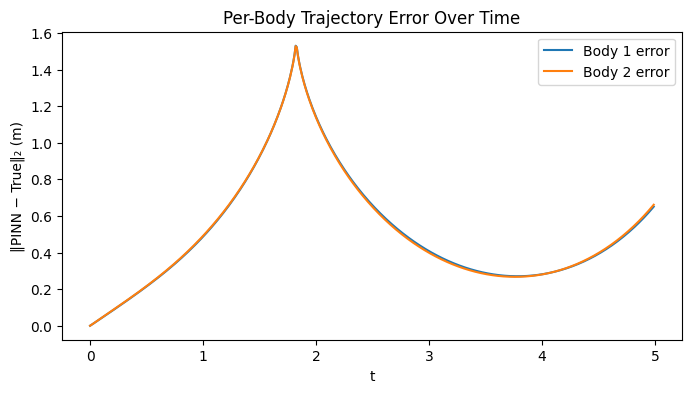

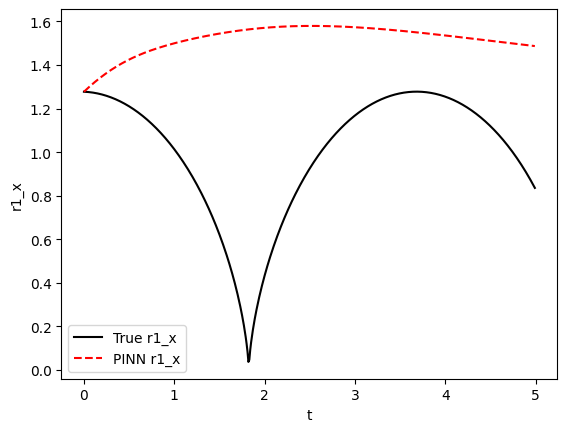

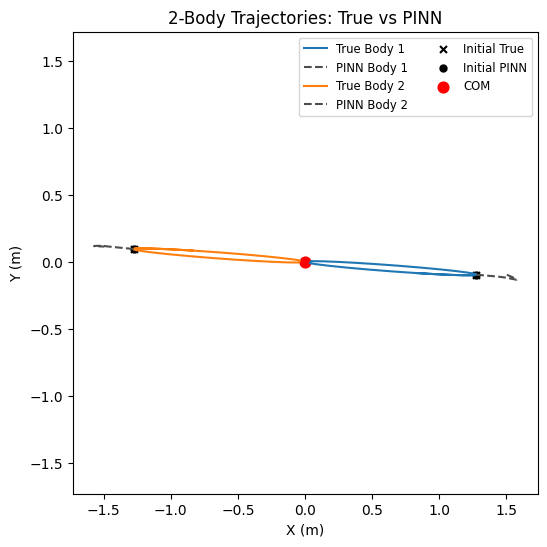

In [21]:
# ─── PLOTTING ─────────────────────────────────────────────────────────────────

# ─── 6b) COMPUTE & PLOT PER-BODY ERRORS ───────────────────────────────────────
errors = np.zeros((Nt, n))
for i in range(n):
    # pick out columns 2*i (x) and 2*i+1 (y)
    true_xy = data_sim[:, 2*i:2*i+2]   # (Nt,2)
    pred_xy = x_pinn[:,  2*i:2*i+2]    # (Nt,2)
    # Euclidean error per time
    errors[:, i] = np.linalg.norm(pred_xy - true_xy, axis=1)

plt.figure(figsize=(8,4))
for i in range(n):
    plt.plot(t_sim, errors[:,i], label=f'Body {i+1} error')
plt.xlabel('t')
plt.ylabel('‖PINN − True‖₂ (m)')
plt.title('Per-Body Trajectory Error Over Time')
plt.legend()
plt.show()



# ─── 6b) PLOT BODY 1 x-position ERRORS ───────────────────────────────────────
plt.figure()
plt.plot(t_sim, data_sim[:,0], 'k-', label='True r1_x')
plt.plot(t_sim, x_pinn[:,0], 'r--', label='PINN r1_x')
plt.legend(); plt.xlabel('t'); plt.ylabel('r1_x'); plt.show()



# ─── 6c) COMPUTE & PLOT Simulation & PINN trajectories ───────────────────────────────────────

data = data_sim.T   # (4n, Nt)

plt.figure(figsize=(6,6))
for i in range(n):
    # True trajectory in color C{i}
    xi = data[2*i,    :]
    yi = data[2*i+1,  :]
    plt.plot(xi, yi, '-', c=f'C{i}', lw=1.5, label=f'True Body {i+1}')

    # PINN trajectory in dark gray
    xi_p = x_pinn[:,2*i]
    yi_p = x_pinn[:,2*i+1]
    plt.plot(xi_p, yi_p, '--', c='0.3', lw=1.5, label=f'PINN Body {i+1}')

# Initial positions
initial_xs = data[0:2*n:2, 0]
initial_ys = data[1:2*n:2, 0]
plt.scatter(initial_xs, initial_ys,
            c='k', marker='x', s=25, label='Initial True')

initial_xs_p = x_pinn[0, 0:2*n:2]
initial_ys_p = x_pinn[0, 1:2*n:2]
plt.scatter(initial_xs_p, initial_ys_p,
            c='k', marker='o', s=25, label='Initial PINN')

# Center of mass
plt.scatter(0,0, marker='o', c='r', s=60, label='COM')

plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories: True vs PINN')
# Deduplicate legend entries so each appears once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small', ncol=2)
plt.show()



In [22]:
# ─── 1) GENERATE SIMULATION DATA ─────────────────────────────────────────────
n      = 2
G      = 3.0
masses = np.ones(n)

# Random ICs centered on COM
L, v_scale = 3.0, 0.5
pos0 = np.random.uniform(-L,L,(n,2))
vel0 = np.random.uniform(-v_scale,v_scale,(n,2))
Mtot = masses.sum()
COM_r = (masses[:,None]*pos0).sum(0)/Mtot
COM_v = (masses[:,None]*vel0).sum(0)/Mtot
pos0 -= COM_r;  vel0 -= COM_v

x0 = np.hstack((pos0.flatten(), vel0.flatten()))
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            rij = pos[i]-pos[j]
            acc[i] += -G*masses[j]*rij/np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

dt, Nt = 0.01, 500
t_sim = np.linspace(0, dt*(Nt-1), Nt)
sol   = solve_ivp(n_body_rhs, (0, t_sim[-1]), x0, t_eval=t_sim,
                  rtol=1e-9, atol=1e-9)
data_sim = sol.y.T  # (Nt,4n)

# Convert to tensors
t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)   # (Nt,1)
x_data = torch.tensor(data_sim, dtype=torch.float32)            # (Nt,4n)

# ─── 2) PINN DEFINITION ──────────────────────────────────────────────────────
class NBodyPINN(nn.Module):
    def __init__(self, n, hidden=[64,64]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

model     = NBodyPINN(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse       = nn.MSELoss()

# ─── 3) COLLocation POINTS ───────────────────────────────────────────────────
Ncol = 500
t_col = torch.tensor(
    np.random.uniform(0, t_sim[-1], (Ncol,1)),
    requires_grad=True,
    dtype=torch.float32
)

# ─── 4) LOSS FUNCTIONS ──────────────────────────────────────────────────────
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    t0     = torch.zeros(1,1) 
    x0_pred= model(t0)  
    x0_true= x_data[:1]  
    Li = mse(x0_pred, x0_true)
    return mse(x0_pred, x0_true)


def physics_loss():
    # Predict at collocation times
    x_pred = model(t_col)              # (Ncol,4n)
    # First derivative per output dim
    x_t_list = []
    for j in range(4*n):
        grad_j = ag.grad(x_pred[:,j], t_col,
                         grad_outputs=torch.ones_like(x_pred[:,j]),
                         create_graph=True)[0]
        x_t_list.append(grad_j)
    x_t = torch.cat(x_t_list, dim=1)   # (Ncol,4n)
    # Second derivative per output dim
    x_tt_list = []
    for j in range(4*n):
        grad2_j = ag.grad(x_t[:,j], t_col,
                          grad_outputs=torch.ones_like(x_t[:,j]),
                          create_graph=True)[0]
        x_tt_list.append(grad2_j)
    x_tt = torch.cat(x_tt_list, dim=1) # (Ncol,4n)

    # Extract predicted positions & accelerations
    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:,  :2*n].view(-1,n,2)

    # Build ODE residual
    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j] * rij / (rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# ─── 5) TRAINING ─────────────────────────────────────────────────────────────────
epochs = 10000

# Stage 1: match data & IC exactly
for epoch in range(500):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 

    loss = Ld + 1000.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")

# Stage 2: add physics back in
for epoch in range(1500):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 
    loss = Ld + Lp + 1000.0*Li

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")


# ─── 6) EVALUATION ──────────────────────────────────────────────────────────
with torch.no_grad():
    x_pinn = model(t_data).cpu().numpy()  # (Nt,4n)

Epoch    0 | Data 1.68e+00 | Phys 3.60e+03 | IC 5.36e-02
Epoch  200 | Data 1.63e+00 | Phys 6.60e+02 | IC 8.61e-10
Epoch  400 | Data 1.63e+00 | Phys 6.33e+02 | IC 7.16e-10
Epoch    0 | Data 1.63e+00 | Phys 6.30e+02 | IC 6.22e-10
Epoch  200 | Data 2.54e+00 | Phys 1.20e+00 | IC 1.49e-04
Epoch  400 | Data 2.45e+00 | Phys 1.15e+00 | IC 1.47e-04
Epoch  600 | Data 2.37e+00 | Phys 1.09e+00 | IC 1.42e-04
Epoch  800 | Data 2.30e+00 | Phys 1.01e+00 | IC 1.34e-04
Epoch 1000 | Data 2.23e+00 | Phys 9.24e-01 | IC 1.22e-04
Epoch 1200 | Data 2.17e+00 | Phys 8.27e-01 | IC 1.07e-04
Epoch 1400 | Data 2.11e+00 | Phys 7.26e-01 | IC 9.11e-05


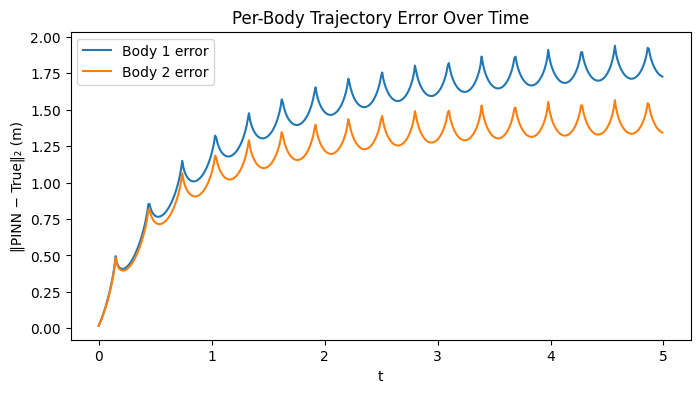

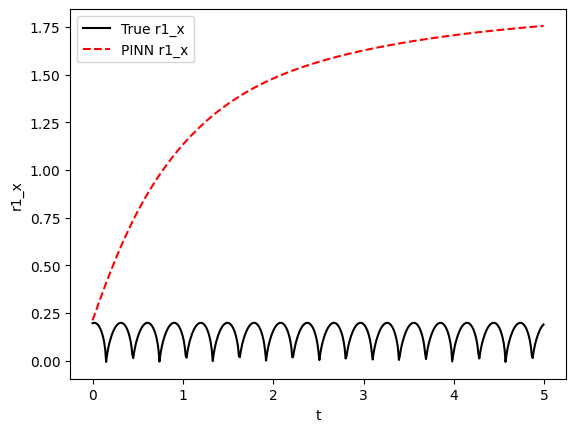

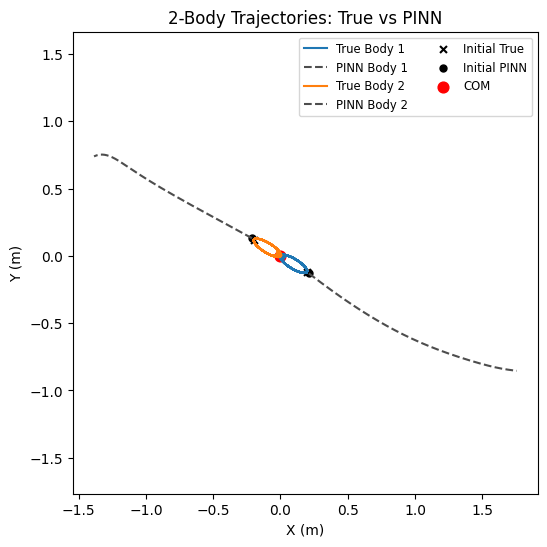

In [23]:
# ─── PLOTTING ─────────────────────────────────────────────────────────────────

# ─── 6b) COMPUTE & PLOT PER-BODY ERRORS ───────────────────────────────────────
errors = np.zeros((Nt, n))
for i in range(n):
    # pick out columns 2*i (x) and 2*i+1 (y)
    true_xy = data_sim[:, 2*i:2*i+2]   # (Nt,2)
    pred_xy = x_pinn[:,  2*i:2*i+2]    # (Nt,2)
    # Euclidean error per time
    errors[:, i] = np.linalg.norm(pred_xy - true_xy, axis=1)

plt.figure(figsize=(8,4))
for i in range(n):
    plt.plot(t_sim, errors[:,i], label=f'Body {i+1} error')
plt.xlabel('t')
plt.ylabel('‖PINN − True‖₂ (m)')
plt.title('Per-Body Trajectory Error Over Time')
plt.legend()
plt.show()



# ─── 6b) PLOT BODY 1 x-position ERRORS ───────────────────────────────────────
plt.figure()
plt.plot(t_sim, data_sim[:,0], 'k-', label='True r1_x')
plt.plot(t_sim, x_pinn[:,0], 'r--', label='PINN r1_x')
plt.legend(); plt.xlabel('t'); plt.ylabel('r1_x'); plt.show()



# ─── 6c) COMPUTE & PLOT Simulation & PINN trajectories ───────────────────────────────────────

data = data_sim.T   # (4n, Nt)

plt.figure(figsize=(6,6))
for i in range(n):
    # True trajectory in color C{i}
    xi = data[2*i,    :]
    yi = data[2*i+1,  :]
    plt.plot(xi, yi, '-', c=f'C{i}', lw=1.5, label=f'True Body {i+1}')

    # PINN trajectory in dark gray
    xi_p = x_pinn[:,2*i]
    yi_p = x_pinn[:,2*i+1]
    plt.plot(xi_p, yi_p, '--', c='0.3', lw=1.5, label=f'PINN Body {i+1}')

# Initial positions
initial_xs = data[0:2*n:2, 0]
initial_ys = data[1:2*n:2, 0]
plt.scatter(initial_xs, initial_ys,
            c='k', marker='x', s=25, label='Initial True')

initial_xs_p = x_pinn[0, 0:2*n:2]
initial_ys_p = x_pinn[0, 1:2*n:2]
plt.scatter(initial_xs_p, initial_ys_p,
            c='k', marker='o', s=25, label='Initial PINN')

# Center of mass
plt.scatter(0,0, marker='o', c='r', s=60, label='COM')

plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories: True vs PINN')
# Deduplicate legend entries so each appears once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small', ncol=2)
plt.show()


In [24]:
################### N-BODY SIMULATION ###################

n      = 2
G      = 3.0
masses = np.ones(n)

# Random ICs centered on COM
L, v_scale = 3.0, 0.5
pos0 = np.random.uniform(-L,L,(n,2))
vel0 = np.random.uniform(-v_scale,v_scale,(n,2))
Mtot = masses.sum()
COM_r = (masses[:,None]*pos0).sum(0)/Mtot
COM_v = (masses[:,None]*vel0).sum(0)/Mtot
pos0 -= COM_r;  vel0 -= COM_v

x0 = np.hstack((pos0.flatten(), vel0.flatten()))
def n_body_rhs(t, state):
    pos = state[:2*n].reshape(n,2)
    vel = state[2*n:4*n].reshape(n,2)
    acc = np.zeros_like(pos)
    for i in range(n):
        for j in range(n):
            if i==j: continue
            rij = pos[i]-pos[j]
            acc[i] += -G*masses[j]*rij/np.linalg.norm(rij)**3
    return np.hstack((vel.flatten(), acc.flatten()))

dt, Nt = 0.01, 500
t_sim = np.linspace(0, dt*(Nt-1), Nt)
sol   = solve_ivp(n_body_rhs, (0, t_sim[-1]), x0, t_eval=t_sim,
                  rtol=1e-9, atol=1e-9)
data_sim = sol.y.T  # (Nt,4n)

# Convert to tensors
t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)   # (Nt,1)
x_data = torch.tensor(data_sim, dtype=torch.float32)            # (Nt,4n)

################### N-BODY SIMULATION ###################

In [26]:
################### TRAINING PHYSICS-INFORMED NN ###################

# ─── 2) PINN DEFINITION ──────────────────────────────────────────────────────
class NBodyPINN(nn.Module):
    def __init__(self, n, hidden=[128,128]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self, t):
        return self.net(t)

model     = NBodyPINN(n)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200, min_lr=1e-6)
mse       = nn.MSELoss()

# ─── 3) COLLocation POINTS ───────────────────────────────────────────────────
Ncol = 500
t_col = torch.tensor(
    np.random.uniform(0, t_sim[-1], (Ncol,1)),
    requires_grad=True,
    dtype=torch.float32
)

# ─── 4) LOSS FUNCTIONS ──────────────────────────────────────────────────────
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    t0     = torch.zeros(1,1) 
    x0_pred= model(t0)  
    x0_true= x_data[:1]  
    Li = mse(x0_pred, x0_true)
    return mse(x0_pred, x0_true)


def physics_loss():
    # Predict at collocation times
    x_pred = model(t_col)              # (Ncol,4n)
    # First derivative per output dim
    x_t_list = []
    for j in range(4*n):
        grad_j = ag.grad(x_pred[:,j], t_col,
                         grad_outputs=torch.ones_like(x_pred[:,j]),
                         create_graph=True)[0]
        x_t_list.append(grad_j)
    x_t = torch.cat(x_t_list, dim=1)   # (Ncol,4n)
    # Second derivative per output dim
    x_tt_list = []
    for j in range(4*n):
        grad2_j = ag.grad(x_t[:,j], t_col,
                          grad_outputs=torch.ones_like(x_t[:,j]),
                          create_graph=True)[0]
        x_tt_list.append(grad2_j)
    x_tt = torch.cat(x_tt_list, dim=1) # (Ncol,4n)

    # Extract predicted positions & accelerations
    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:,  :2*n].view(-1,n,2)

    # Build ODE residual
    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j] * rij / (rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# ─── 5) TRAINING ─────────────────────────────────────────────────────────────────
epochs = 10000
ld_rate = 5
lp_rate = 1
li_rate = 1000

# Stage 1: match data & IC exactly
for epoch in range(20000):
    optimizer.zero_grad()
    Ld = data_loss()     
    Lp = physics_loss()
    Li = ic_loss() 
    loss = ld_rate*Ld + lp_rate*Lp + li_rate*Li
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Data {Ld:.2e} | Phys {Lp:.2e} | IC {Li:.2e}")

# ─── 6) EVALUATION ──────────────────────────────────────────────────────────
with torch.no_grad():
    x_pinn = model(t_data).cpu().numpy()  # (Nt,4n)

################### TRAINING PHYSICS-INFORMED NN ###################


Epoch    0 | Data 1.04e+00 | Phys 9.49e+01 | IC 1.47e-01
Epoch  200 | Data 1.17e+00 | Phys 1.02e+00 | IC 4.87e-05
Epoch  400 | Data 1.10e+00 | Phys 6.86e-01 | IC 8.45e-06
Epoch  600 | Data 1.08e+00 | Phys 5.60e-01 | IC 3.74e-06
Epoch  800 | Data 1.07e+00 | Phys 4.70e-01 | IC 1.60e-06
Epoch 1000 | Data 1.07e+00 | Phys 4.04e-01 | IC 4.83e-07
Epoch 1200 | Data 1.07e+00 | Phys 3.69e-01 | IC 9.20e-08
Epoch 1400 | Data 1.07e+00 | Phys 3.55e-01 | IC 1.26e-08
Epoch 1600 | Data 1.07e+00 | Phys 3.49e-01 | IC 5.55e-09
Epoch 1800 | Data 1.07e+00 | Phys 3.46e-01 | IC 9.97e-09
Epoch 2000 | Data 1.07e+00 | Phys 3.44e-01 | IC 1.47e-08
Epoch 2200 | Data 1.07e+00 | Phys 3.43e-01 | IC 1.83e-08
Epoch 2400 | Data 1.07e+00 | Phys 3.42e-01 | IC 2.07e-08
Epoch 2600 | Data 1.07e+00 | Phys 3.41e-01 | IC 2.24e-08
Epoch 2800 | Data 1.07e+00 | Phys 3.40e-01 | IC 2.45e-08
Epoch 3000 | Data 1.07e+00 | Phys 3.39e-01 | IC 5.43e-08
Epoch 3200 | Data 1.07e+00 | Phys 3.38e-01 | IC 3.50e-08
Epoch 3400 | Data 1.07e+00 | Ph

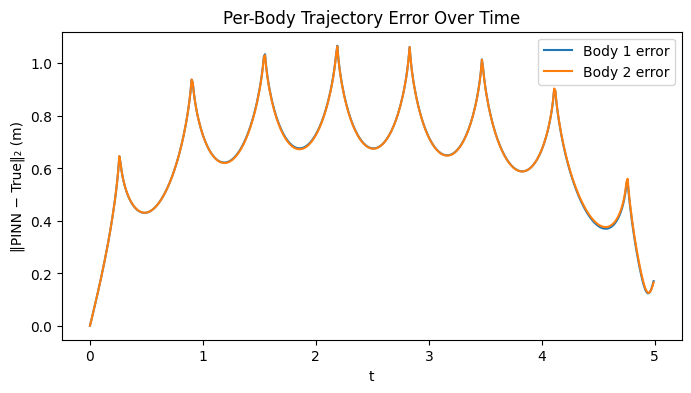

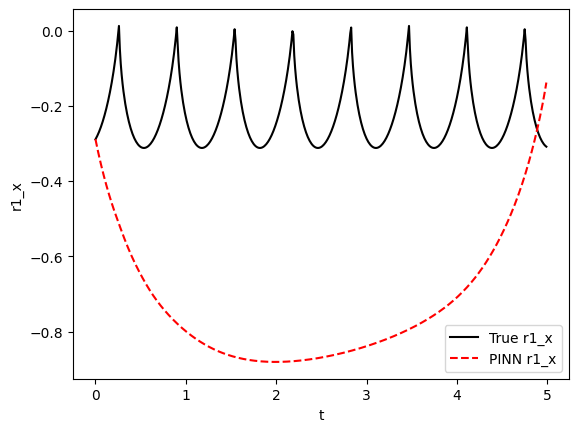

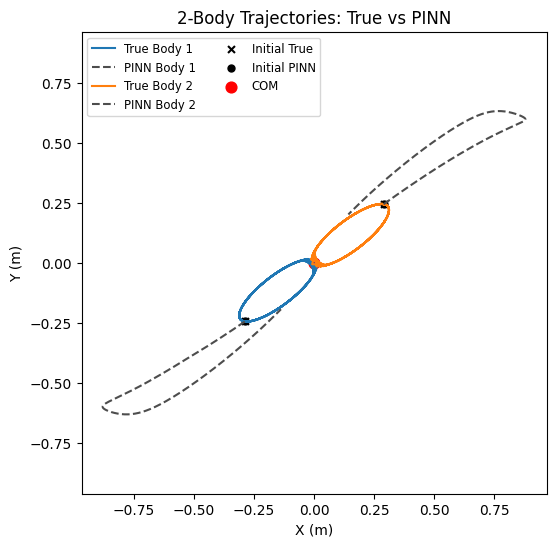

In [27]:
# ─── PLOTTING ─────────────────────────────────────────────────────────────────

# ─── 6b) COMPUTE & PLOT PER-BODY ERRORS ───────────────────────────────────────
errors = np.zeros((Nt, n))
for i in range(n):
    # pick out columns 2*i (x) and 2*i+1 (y)
    true_xy = data_sim[:, 2*i:2*i+2]   # (Nt,2)
    pred_xy = x_pinn[:,  2*i:2*i+2]    # (Nt,2)
    # Euclidean error per time
    errors[:, i] = np.linalg.norm(pred_xy - true_xy, axis=1)

plt.figure(figsize=(8,4))
for i in range(n):
    plt.plot(t_sim, errors[:,i], label=f'Body {i+1} error')
plt.xlabel('t')
plt.ylabel('‖PINN − True‖₂ (m)')
plt.title('Per-Body Trajectory Error Over Time')
plt.legend()
plt.show()



# ─── 6b) PLOT BODY 1 x-position ERRORS ───────────────────────────────────────
plt.figure()
plt.plot(t_sim, data_sim[:,0], 'k-', label='True r1_x')
plt.plot(t_sim, x_pinn[:,0], 'r--', label='PINN r1_x')
plt.legend(); plt.xlabel('t'); plt.ylabel('r1_x'); plt.show()



# ─── 6c) COMPUTE & PLOT Simulation & PINN trajectories ───────────────────────────────────────

data = data_sim.T   # (4n, Nt)

plt.figure(figsize=(6,6))
for i in range(n):
    # True trajectory in color C{i}
    xi = data[2*i,    :]
    yi = data[2*i+1,  :]
    plt.plot(xi, yi, '-', c=f'C{i}', lw=1.5, label=f'True Body {i+1}')

    # PINN trajectory in dark gray
    xi_p = x_pinn[:,2*i]
    yi_p = x_pinn[:,2*i+1]
    plt.plot(xi_p, yi_p, '--', c='0.3', lw=1.5, label=f'PINN Body {i+1}')

# Initial positions
initial_xs = data[0:2*n:2, 0]
initial_ys = data[1:2*n:2, 0]
plt.scatter(initial_xs, initial_ys,
            c='k', marker='x', s=25, label='Initial True')

initial_xs_p = x_pinn[0, 0:2*n:2]
initial_ys_p = x_pinn[0, 1:2*n:2]
plt.scatter(initial_xs_p, initial_ys_p,
            c='k', marker='o', s=25, label='Initial PINN')

# Center of mass
plt.scatter(0,0, marker='o', c='r', s=60, label='COM')

plt.axis('equal')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')
plt.title(f'{n}-Body Trajectories: True vs PINN')
# Deduplicate legend entries so each appears once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small', ncol=2)
plt.show()

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag
import matplotlib.pyplot as plt
import glob, os

In [30]:
# -----------------------------
# 1. Load and Prepare the Dataset
# -----------------------------
n = 3
sim_dir = f'simulations/nbody_{n:02d}'
sim_files = sorted(glob.glob(os.path.join(sim_dir, '*.npz')))

# Load all data
t_list, x_list = [], []
for file in sim_files:
    data = np.load(file)
    t_list.append(data['t_sim'])     # shape (Nt,)
    x_list.append(data['data_sim'])  # shape (Nt,4n)

t_array = np.stack(t_list)   # (Nsims, Nt)
x_array = np.stack(x_list)   # (Nsims, Nt, 4n)
Nsims, Nt, _ = x_array.shape

# Train/validation split
Ntrain = int(0.8 * Nsims)
Nval = Nsims - Ntrain

t_train = torch.tensor(t_array[:Ntrain,:,:], dtype=torch.float32)
x_train = torch.tensor(x_array[:Ntrain,:,:], dtype=torch.float32)

t_val = torch.tensor(t_array[Ntrain:,:,:], dtype=torch.float32)
x_val = torch.tensor(x_array[Ntrain:,:,:], dtype=torch.float32)

# Flatten across all training sims
t_train = t_train.reshape(-1,1)   # (Ntrain*Nt,1)
x_train = x_train.reshape(-1,4*n) # (Ntrain*Nt,4n)
t_val   = t_val.reshape(-1,1)
x_val   = x_val.reshape(-1,4*n)

print(f"Loaded {Ntrain} training sims and {Nval} validation sims")

# -----------------------------
# 2. Define PINN Architecture
# -----------------------------
class PINN(nn.Module):
    def __init__(self, n, hidden=[128,128]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

model = PINN(n).float()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, min_lr=1e-6)
mse = nn.MSELoss()

G = 1.0
masses = np.ones(n)

# -----------------------------
# 3. Define Loss Functions
# -----------------------------
Ncol = 2000
t_col = torch.tensor(np.random.uniform(0, t_array.max(), (Ncol,1)),
                     requires_grad=True, dtype=torch.float32)

def data_loss(t,x):
    return mse(model(t), x)

def ic_loss(t,x):
    x0_pred = model(torch.zeros(1,1))
    x0_true = x[0:1]
    return mse(x0_pred, x0_true)

def physics_loss():
    x_pred = model(t_col)
    x_t = torch.cat([
        ag.grad(x_pred[:,j], t_col, grad_outputs=torch.ones_like(x_pred[:,j]), create_graph=True)[0].unsqueeze(1)
        for j in range(4*n)], dim=1)
    x_tt = torch.cat([
        ag.grad(x_t[:,j], t_col, grad_outputs=torch.ones_like(x_t[:,j]), create_graph=True)[0].unsqueeze(1)
        for j in range(4*n)], dim=1)

    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:, :2*n].view(-1,n,2)

    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i] - pos_pred[:,j]
            force_sum += -G*masses[j]*rij/(rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# -----------------------------
# 4. Training
# -----------------------------
epochs = 5000
ld_rate = 5
lp_rate = 1
li_rate = 1000

for epoch in range(epochs):
    optimizer.zero_grad()

    if epoch < 1000:    # Warmup
        loss = ld_rate*data_loss(t_train, x_train) + li_rate*ic_loss(t_train,x_train)
    elif epoch < 4000:  # Ramp-up physics
        frac = (epoch-1000)/3000
        loss = ld_rate*data_loss(t_train, x_train) + lp_rate*frac*physics_loss() + li_rate*ic_loss(t_train,x_train)
    else:               # Full loss
        loss = ld_rate*data_loss(t_train, x_train) + lp_rate*physics_loss() + li_rate*ic_loss(t_train,x_train)

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | Loss {loss.item():.3e}")

# -----------------------------
# 5. Evaluation
# -----------------------------
model.eval()
with torch.no_grad():
    x_train_pred = model(t_train).cpu().numpy()
    x_val_pred = model(t_val).cpu().numpy()

# Compute RMSE
train_rmse = np.sqrt(np.mean((x_train_pred - x_train.cpu().numpy())**2))
val_rmse = np.sqrt(np.mean((x_val_pred - x_val.cpu().numpy())**2))
print(f"\nTraining RMSE: {train_rmse:.3e}")
print(f"Validation RMSE: {val_rmse:.3e}")

# -----------------------------
# 6. Physics Residual Evaluation
# -----------------------------
# Recompute physics loss on random collocation points
physics_residual = physics_loss().item()
print(f"Final Physics Residual: {physics_residual:.3e}")

# -----------------------------
# 7. Energy Conservation Evaluation
# -----------------------------
# Evaluate Energy Drift on validation set
def compute_energy(x_data):
    pos = x_data[:, :2*n].reshape(-1,n,2)
    vel = x_data[:, 2*n:].reshape(-1,n,2)

    KE = 0.5 * np.sum(np.sum(vel**2, axis=2), axis=1)   # kinetic energy
    PE = np.zeros(vel.shape[0])
    for i in range(n):
        for j in range(i+1,n):
            rij = np.linalg.norm(pos[:,i]-pos[:,j], axis=1)
            PE -= G / rij
    H = KE + PE
    return H

H_val = compute_energy(x_val.cpu().numpy())
energy_drift = np.abs(H_val - H_val[0]).max()
print(f"Energy Drift on Validation Set: {energy_drift:.3e}")

# Plot Energy if wanted
plt.figure()
plt.plot(H_val, label='Total Energy')
plt.xlabel('Time Step')
plt.ylabel('Energy')
plt.title('Energy Conservation Check')
plt.legend()
plt.show()



RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x17 and 18x128)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as ag
import matplotlib.pyplot as plt
import glob, os


In [2]:

# Select n-body simulation to train on
n = 5
sim_dir = f'simulations/nbody_{n:02d}'
sim_file = glob.glob(os.path.join(sim_dir, '*.npz'))[0]  # pick first sim for example

data = np.load(sim_file)
t_sim = data['t_sim']
data_sim = data['data_sim']

t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)
x_data = torch.tensor(data_sim, dtype=torch.float32)

# Constants used in simulation
G = 1.0
masses = np.ones(n)

# --- PINN Architecture (MLP) ---
class PINN(nn.Module):
    def __init__(self, n, hidden=[128,128]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

model = PINN(n).float()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, min_lr=1e-6)
mse = nn.MSELoss()

# Collocation points
Ncol = 1000
t_col = torch.tensor(np.random.uniform(0, t_sim[-1], (Ncol,1)),
                     requires_grad=True, dtype=torch.float32)

# --- Loss Functions ---
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    x0_pred = model(torch.zeros(1,1))
    return mse(x0_pred, x_data[0:1])

def physics_loss():
    x_pred = model(t_col)
    x_t = torch.cat([
        ag.grad(x_pred[:,j], t_col, grad_outputs=torch.ones_like(x_pred[:,j]), create_graph=True)[0].unsqueeze(1)
        for j in range(4*n)], dim=1)
    x_tt = torch.cat([
        ag.grad(x_t[:,j], t_col, grad_outputs=torch.ones_like(x_t[:,j]), create_graph=True)[0].unsqueeze(1)
        for j in range(4*n)], dim=1)

    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:, :2*n].view(-1,n,2)

    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i]-pos_pred[:,j]
            force_sum += -G*masses[j]*rij/(rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# --- Multi-phase Training ---
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    if epoch < 1000:    # Phase 1: Data & IC only
        loss = data_loss() + 1000*ic_loss()
    elif epoch < 4000:  # Phase 2: Ramp up physics
        frac = (epoch-1000)/3000
        loss = data_loss() + (frac)*physics_loss() + 1000*ic_loss()
    else:               # Phase 3: All losses
        loss = data_loss() + physics_loss() + 1000*ic_loss()

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.3e}")

# --- Evaluate ---
model.eval()
with torch.no_grad():
    x_pinn = model(t_data).cpu().numpy()

# RMSE calculation
rmse = np.sqrt(np.mean((x_pinn - data_sim)**2))
print(f'Overall RMSE: {rmse:.3e}')


Epoch 0, Loss 5.919e+02
Epoch 500, Loss 5.954e-01
Epoch 1000, Loss 5.432e-01
Epoch 1500, Loss 4.562e+00
Epoch 2000, Loss 4.197e+00
Epoch 2500, Loss 4.205e+00
Epoch 3000, Loss 4.337e+00
Epoch 3500, Loss 4.534e+00
Epoch 4000, Loss 4.769e+00
Epoch 4500, Loss 4.718e+00
Overall RMSE: 1.408e+00


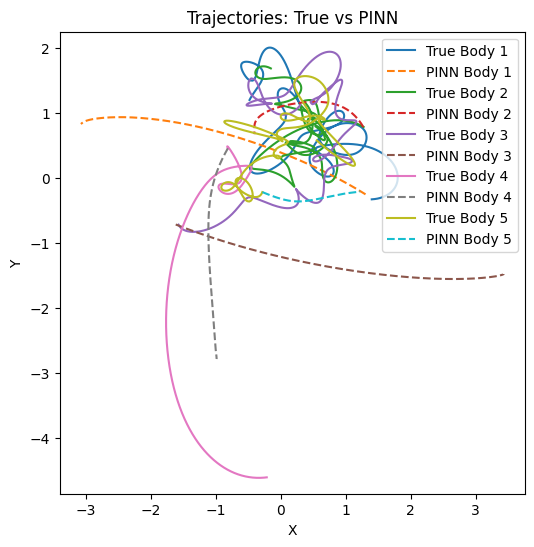

In [3]:
# --- Plot Trajectories ---
plt.figure(figsize=(6,6))
for i in range(n):
    plt.plot(data_sim[:,2*i], data_sim[:,2*i+1], '-', label=f'True Body {i+1}')
    plt.plot(x_pinn[:,2*i], x_pinn[:,2*i+1], '--', label=f'PINN Body {i+1}')
plt.legend()
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Trajectories: True vs PINN')
plt.axis('equal')
plt.show()


In [20]:

# Select n-body simulation to train on
n = 4
sim_dir = f'simulations/nbody_{n:02d}'
sim_file = glob.glob(os.path.join(sim_dir, '*.npz'))[0]  # pick first sim for example

data = np.load(sim_file)
t_sim = data['t_sim']
data_sim = data['data_sim']

t_data = torch.tensor(t_sim, dtype=torch.float32).unsqueeze(1)
x_data = torch.tensor(data_sim, dtype=torch.float32)

# Constants used in simulation
G = 1.0
masses = np.ones(n)

# --- PINN Architecture (MLP) ---
class PINN(nn.Module):
    def __init__(self, n, hidden=[128,128]):
        super().__init__()
        dims = [1] + hidden + [4*n]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

model = PINN(n).float()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, min_lr=1e-6)
mse = nn.MSELoss()

# Collocation points
Ncol = 1000
t_col = torch.tensor(np.random.uniform(0, t_sim[-1], (Ncol,1)),
                     requires_grad=True, dtype=torch.float32)

# --- Loss Functions ---
def data_loss():
    return mse(model(t_data), x_data)

def ic_loss():
    x0_pred = model(torch.zeros(1,1))
    return mse(x0_pred, x_data[0:1])

def physics_loss():
    x_pred = model(t_col)
    x_t = torch.cat([
        ag.grad(x_pred[:,j], t_col, grad_outputs=torch.ones_like(x_pred[:,j]), create_graph=True)[0].unsqueeze(1)
        for j in range(4*n)], dim=1)
    x_tt = torch.cat([
        ag.grad(x_t[:,j], t_col, grad_outputs=torch.ones_like(x_t[:,j]), create_graph=True)[0].unsqueeze(1)
        for j in range(4*n)], dim=1)

    pos_pred = x_pred[:, :2*n].view(-1,n,2)
    acc_pred = x_tt[:, :2*n].view(-1,n,2)

    loss_p = 0.0
    for i in range(n):
        force_sum = torch.zeros_like(acc_pred[:,i])
        for j in range(n):
            if i==j: continue
            rij = pos_pred[:,i]-pos_pred[:,j]
            force_sum += -G*masses[j]*rij/(rij.norm(dim=1,keepdim=True)**3)
        loss_p += mse(acc_pred[:,i], force_sum)
    return loss_p

# --- Multi-phase Training ---
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    if epoch < 1000:    # Phase 1: Data & IC only
        loss = data_loss() + 1000*ic_loss()
    elif epoch < 4000:  # Phase 2: Ramp up physics
        frac = (epoch-1000)/3000
        loss = data_loss() + (frac)*physics_loss() + 1000*ic_loss()
    else:               # Phase 3: All losses
        loss = data_loss() + physics_loss() + 1000*ic_loss()

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss {loss.item():.3e}")

# --- Evaluate ---
model.eval()
with torch.no_grad():
    x_pinn = model(t_data).cpu().numpy()

# RMSE calculation
rmse = np.sqrt(np.mean((x_pinn - data_sim)**2))
print(f'Overall RMSE: {rmse:.3e}')


Epoch 0, Loss 1.624e+03
Epoch 500, Loss 7.318e-01
Epoch 1000, Loss 6.649e-01
Epoch 1500, Loss 9.343e-01
Epoch 2000, Loss 9.681e-01
Epoch 2500, Loss 9.865e-01
Epoch 3000, Loss 1.003e+00
Epoch 3500, Loss 1.023e+00
Epoch 4000, Loss 1.046e+00


KeyboardInterrupt: 

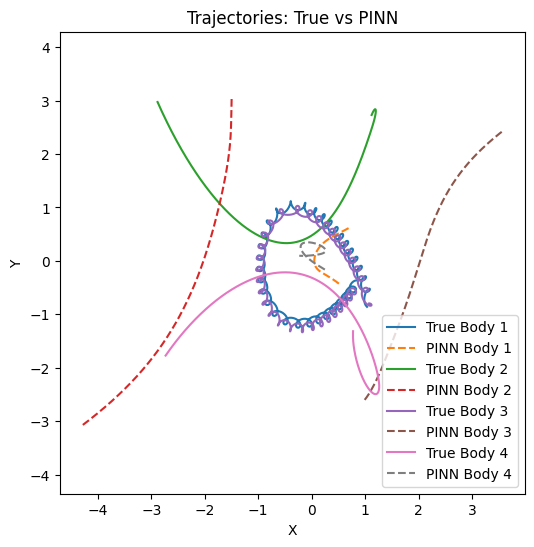

In [21]:
# --- Plot Trajectories ---
plt.figure(figsize=(6,6))
for i in range(n):
    plt.plot(data_sim[:,2*i], data_sim[:,2*i+1], '-', label=f'True Body {i+1}')
    plt.plot(x_pinn[:,2*i], x_pinn[:,2*i+1], '--', label=f'PINN Body {i+1}')
plt.legend()
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Trajectories: True vs PINN')
plt.axis('equal')
plt.show()


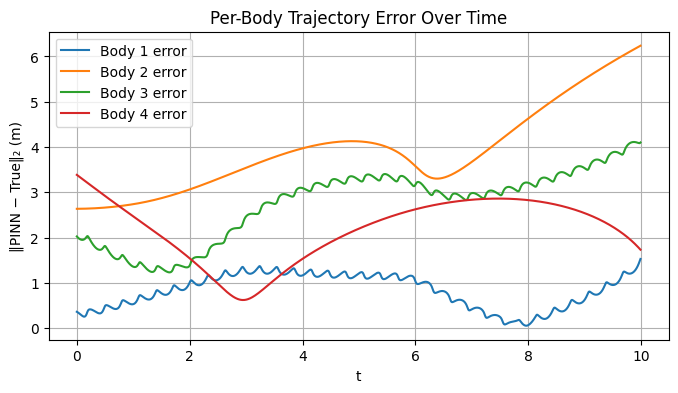

In [22]:
# Compute error for each body
Nt = data_sim.shape[0]
n = data_sim.shape[1] // 4  # each body has x, y, vx, vy
errors = np.zeros((Nt, n))

for i in range(n):
    true_xy = data_sim[:, 2*i:2*i+2]   # true x, y
    pred_xy = x_pinn[:,  2*i:2*i+2]    # predicted x, y
    errors[:, i] = np.linalg.norm(pred_xy - true_xy, axis=1)

# Plot error over time
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
for i in range(n):
    plt.plot(t_sim, errors[:, i], label=f'Body {i+1} error')
plt.xlabel('t')
plt.ylabel('‖PINN − True‖₂ (m)')
plt.title('Per-Body Trajectory Error Over Time')
plt.legend()
plt.grid(True)
plt.show()
